<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-i_am_not_a_robot/blob/main/captcha_test_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test of captcha code recognition using OCR model by keras.

This code is inspired by 
* https://keras.io/examples/vision/captcha_ocr/
* https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c
* https://www.youtube.com/watch?v=SHo3hbsJs_U&ab_channel=HenryAILabs 

## Work space


In [14]:
# install and load packages
! pip install patool
! pip install pyunpack

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from pyunpack import Archive
import glob
import string
from PIL import Image

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()

print(f'We are now using {device}. There are {n_cudas} available gpus.')

if torch.cuda.is_available():
    print(f'{torch.cuda.get_device_name(0)}')

We are now using cpu. There are 0 available gpus.


# Data preprocessing

Train data available at: https://drive.google.com/file/d/1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G

Test data available at: https://drive.google.com/file/d/1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y

## Dimension
(No. files x width x height x channels)

Size of train data: 199 987 x 180 x 60 x 3

Size of test data: 49 998 x 180 x 60 x 3

In [16]:
# download files from google drive

# load train data
!gdown --id 1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G
# load test data
!gdown --id 1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y

# create folders to unzip data
! mkdir 'train'
! mkdir 'test'

# unzip data
Archive('captcha_train.tar.gz').extractall('train')
Archive('captcha_test.tar.gz').extractall('test')

# check number of files
train_labels = os.listdir('train/train')
print('train files:', len(train_labels))

test_labels = os.listdir('test/test')
print('test files:', len(test_labels))

Downloading...
From: https://drive.google.com/uc?id=1AswiYpd_CIab6swI-XA88H_IBj0Dyd3G
To: /content/captcha_train.tar.gz
100% 1.92G/1.92G [00:22<00:00, 86.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AsOV43Wc_ZR_1yMbesvq0uNAlUrqK7_Y
To: /content/captcha_test.tar.gz
100% 480M/480M [00:03<00:00, 133MB/s]
mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists
train files: 199987
test files: 49998


## Setup

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
# Path to the data directory
data_dir_train = Path("./train/train")
data_dir_test = Path("./test/test")

# Get list of all the images
images_train = sorted(list(map(str, list(data_dir_train.glob("*.png")))))
images_test = sorted(list(map(str, list(data_dir_test.glob("*.png")))))

labels_train = [img.split(os.path.sep)[-1].split(".png")[0] for img in images_train]
labels_test = [img.split(os.path.sep)[-1].split(".png")[0] for img in images_test]

characters_train = set(char for label in labels_train for char in label)
characters_test = set(char for label in labels_test for char in label)

print("Number of train images found: ", len(images_train))
print("Number of test images found: ", len(images_test))

print("Number of train labels found: ", len(labels_train))
print("Number of test labels found: ", len(labels_test))

print("Number of unique train characters: ", len(characters_train))
print("Number of unique test characters: ", len(characters_test))

print("Characters present in train: ", characters_train)
print("Characters present in test: ", characters_test)

# Batch size for training and validation
batch_size = 4

# Desired image dimensions
img_width = 180
img_height = 60

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length_train = max([len(label) for label in labels_train])
max_length_test = max([len(label) for label in labels_test])
max_length = max([max_length_train,max_length_test])

Number of train images found:  199987
Number of test images found:  49998
Number of train labels found:  199987
Number of test labels found:  49998
Number of unique train characters:  62
Number of unique test characters:  62
Characters present in train:  {'y', '4', 'J', 'i', 'b', 'K', 'R', 'c', 'W', '8', 'S', 'U', 'x', 'I', 'k', '9', 'n', 'z', 'e', 'f', '7', 'C', 's', 't', 'H', 'V', '1', 'Y', 'r', 'h', 'd', 'j', 'F', 'L', '3', 'P', 'M', 'u', 'p', 'm', 'o', 'O', '0', 'Q', 'D', 'X', 'Z', 'v', 'G', 'g', 'l', '5', 'T', 'a', 'E', 'N', 'B', 'w', '2', 'q', '6', 'A'}
Characters present in test:  {'y', 'J', 'i', '4', 'b', 'K', 'R', 'c', 'W', '8', 'S', 'U', 'A', 'x', 'I', 'k', 'z', 'n', '9', 'e', 'f', '7', 'C', 'q', 's', 't', 'H', 'V', 'Y', '1', 'F', 'd', 'r', 'j', 'h', 'L', '3', 'M', 'P', 'p', 'O', 'o', '0', 'Q', 'D', 'X', 'Z', 'v', 'G', 'g', 'l', '5', 'T', 'a', 'E', 'N', 'B', 'w', '2', 'u', '6', 'm'}


## Preprocessing

In [19]:
# Mapping characters to integers
char_to_num_train = layers.StringLookup(
    vocabulary=list(characters_train), mask_token=None)
char_to_num_test = layers.StringLookup(
    vocabulary=list(characters_test), mask_token=None)


# Mapping integers back to original characters
num_to_char_train = layers.StringLookup(
    vocabulary=char_to_num_train.get_vocabulary(), mask_token=None, invert=True)
num_to_char_test = layers.StringLookup(
    vocabulary=char_to_num_test.get_vocabulary(), mask_token=None, invert=True)

In [20]:
#x_train, y_train = images_train, labels_train
#x_valid, y_valid = images_test, labels_test

x_train, y_train = images_train[0:900], labels_train[0:900]
x_valid, y_valid = images_test[901:1000], labels_test[901:1000]

In [21]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num_train(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

## Create Dataset objects

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Model

In [23]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num_train.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 180, 60, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 180, 60, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 90, 30, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 90, 30, 64)   18496       ['pool1[0][0]']       

## Training

In [24]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
225/225 [==============================] - 74s 247ms/step - loss: 25.2286 - val_loss: 29.4232
Epoch 2/100
225/225 [==============================] - 60s 265ms/step - loss: 21.4789 - val_loss: 30.6187
Epoch 3/100
225/225 [==============================] - 42s 185ms/step - loss: 20.8534 - val_loss: 31.1543
Epoch 4/100
225/225 [==============================] - 42s 185ms/step - loss: 20.2271 - val_loss: 31.7112
Epoch 5/100
225/225 [==============================] - 40s 179ms/step - loss: 19.9065 - val_loss: 32.7130
Epoch 6/100
225/225 [==============================] - 40s 179ms/step - loss: 19.5413 - val_loss: 33.8523
Epoch 7/100
225/225 [==============================] - 41s 182ms/step - loss: 19.5208 - val_loss: 33.0938
Epoch 8/100
225/225 [==============================] - 41s 182ms/step - loss: 19.1932 - val_loss: 35.2020
Epoch 9/100
225/225 [==============================] - 40s 179ms/step - loss: 19.1836 - val_loss: 40.6485
Epoch 10/100
225/225 [========================

## Inference

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 180, 60, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 180, 60, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 90, 30, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 90, 30, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 45, 15, 64)        0         
                                                                 
 reshape (Reshape)           (None, 45, 960)           0         
                                                                 
 dense1 (Dense)              (None, 45, 64)            6150

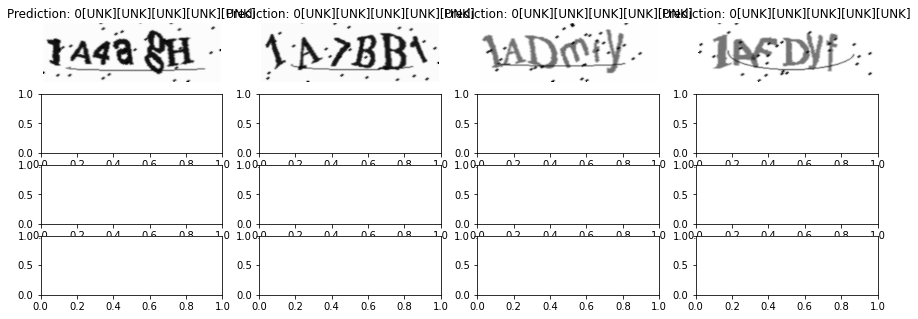

In [25]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char_train(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char_train(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()